In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.neighbors import KernelDensity 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [2]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, isotropic, beta, avg_noise):
        super().__init__()
        self.isotropic = isotropic
        self.latent_size = 3 if self.isotropic else 5 # 5: mean (2) and std (3), 3: mean (2) and log_std (1) 
        self.beta = beta

        self.linear0 = nn.Linear(input_size, hidden_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size) 
        self.linear2 = nn.Linear(hidden_size, self.latent_size) 

        self.linear3 = nn.Linear(input_size, hidden_size) # reparameterization to 2-dim signal 
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, input_size) # output dim is same as input

        self.avg_noise = avg_noise

    def encode(self, x):
        h1 = self.linear2(F.leaky_relu(self.linear1(F.leaky_relu(self.linear0(x)))))

        if self.isotropic: 
            return h1[:,:2], h1[:,-1][:,None] 
        else: 
            return h1[:,:2], h1[:,-3::] 

    def build_L(self, sig_chol):
        # from lower triangular matrix L, get \Sigma=LL^T
        L = torch.randn(sig_chol.shape[0],2,2).to(sig_chol.device)
        L[:,0,0] = sig_chol[:,0]
        L[:,1,0] = sig_chol[:,1]
        L[:,1,1] = sig_chol[:,2]
        return L 
        
    def reparameterize(self, mu, log_std):
        if self.isotropic:
            std = torch.exp(log_std) # we model the log-std dev. 
            eps = torch.randn_like(mu)
            return mu + eps*std
        else: 
            L = self.build_L(log_std) # log_std contains the entries of the lower triangular matrix (Cholesky decomp.)
            eps = torch.randn_like(mu)
            return mu + torch.einsum('bij,bj->bi', L, eps)

    def decode(self, z):
        return self.linear5(F.leaky_relu(self.linear4(F.leaky_relu(self.linear3(z)))))

    def forward(self, x):
        mu, log_std = self.encode(x)

        rec = torch.zeros(x.shape[0],self.avg_noise,x.shape[-1],device=x.device)
        for j in range(self.avg_noise):
            rec[:,j,:] = self.decode(self.reparameterize(mu, log_std))

        return rec, mu, log_std

    def loss_function_isotropic(self, x_rec, x, mu, log_std, sigma=1.):
        rec_loss = (1/sigma**2)*0.5*((x_rec - x[:,None,:])**2).sum(-1).mean(1).mean(0)
        kld_loss = -2*log_std.mean() + (torch.exp(log_std)**2).mean() + 0.5*(mu**2).sum(-1).mean()
        return rec_loss, kld_loss

    def loss_function_fullcov(self, x_rec, x, mu, Sig):
        rec_loss = 0.5*((x_rec - x[:,None,:])**2).sum(-1).mean(1).mean(0)

        log_var = -0.5*torch.log(torch.linalg.det(Sig) + 1e-6).mean()
        var_sq = 0.5*(Sig[:,0,0] + Sig[:,1,1]).mean()
        mu_sq = 0.5*(mu**2).sum(-1).mean()

        return rec_loss, log_var + var_sq + mu_sq 

    def fit(self, x, max_iter, lr):
        self.device = x.device
        optim = Adam(self.parameters(), lr=lr)
        self.train()
        total_loss, rec_loss, kld_loss = [], [], []

        for iter in range(max_iter):
            if self.isotropic: # version 1: isotropic noise
                x_rec, mu, log_std = self(x) 
                l2, kld = self.loss_function_isotropic(x_rec, x, mu, log_std)
                
            else: # version 2: full covariance matrix
                x_rec, mu, sig_chol = self(x)
                L = self.build_L(sig_chol)
                var = torch.einsum('bij,bjk->bik',L,torch.permute(L,(0,2,1)))
                l2, kld = self.loss_function_fullcov(x_rec, x, mu, var)

            loss = self.beta*l2 + kld
            
            total_loss.append(loss.item())
            rec_loss.append(l2.item())
            kld_loss.append(kld.item())

            optim.zero_grad()
            loss.backward()
            optim.step()

            x = shuffle(x)

        return [total_loss, rec_loss, kld_loss]

    def sample(self, n_samples):
        with torch.no_grad():
            latents = torch.randn(n_samples, 2).to(self.device) # TODO: 2
            return self.decode(latents)

torch.Size([2000, 2])


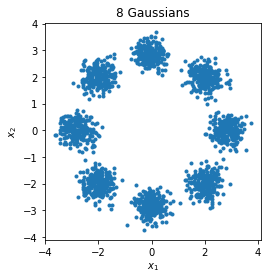

In [7]:
# generate data
n_samples = 2000
z = torch.randn(n_samples, 2)

sq = 1./np.sqrt(2)
fact = 4.*sq
mus = [fact*torch.Tensor([[1.],[0.]]), fact*torch.Tensor([[-1.],[0.]]), fact*torch.Tensor([[0.],[1.]]), fact*torch.Tensor([[0.],[-1.]]),\
    fact*torch.Tensor([[sq],[sq]]), fact*torch.Tensor([[-sq],[sq]]), fact*torch.Tensor([[sq],[-sq]]), fact*torch.Tensor([[-sq],[-sq]])]

sig = 0.1 * torch.Tensor([[1.,0.0],[0.0,1.]])
x_all = [mu + torch.linalg.cholesky(sig)@torch.randn(2,int(n_samples/8.)) for mu in mus]
x = torch.hstack(x_all).T
mus = torch.hstack(mus) # 2,8
print(x.shape)

fig, ax = plt.subplots(1,1)
ax.set_aspect('equal', 'box')
ax.scatter(x[:,0],x[:,1],marker='.'), plt.title('8 Gaussians')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

In [4]:
# settings 
max_iter = 4000
lr = 1.0E-2
beta = 100.
size_hidden = 128

In [5]:
# training
isotropic = True # True, False
vae = VAE(input_size=2, hidden_size=64, isotropic=isotropic, beta=beta, avg_noise=10)

# run on GPU
# x = x.cuda()
# vae = vae.cuda()
losses = vae.fit(x, max_iter=max_iter, lr=lr)


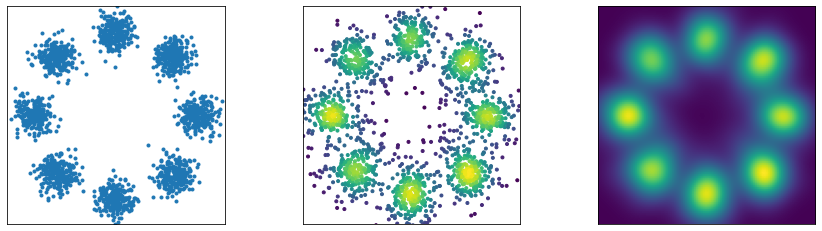

In [6]:
# sample
samples = vae.sample(n_samples=n_samples)
samples = samples.cpu().numpy()

# kde
kde = KernelDensity(bandwidth=.4).fit(samples)
xx, yy = np.meshgrid(np.linspace(x.min().item(),x.max().item(),100),np.linspace(x.min().item(),x.max().item(),100))
x_grid = np.stack((xx.ravel(), yy.ravel()),1)
density = np.exp(kde.score_samples(x_grid))

samples_kde = np.exp(kde.score_samples(samples))
    
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(x[:,0].cpu(),x[:,1].cpu(),marker='.')
ax1.set_xlim([x.min().item(),x.max().item()]), ax1.set_ylim([x.min().item(),x.max().item()])
ax1.set_aspect('equal')
ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1, 3, 2, sharex = ax1,sharey=ax1)
ax2.scatter(samples[:,0],samples[:,1],marker='.',c=samples_kde)
ax2.set_aspect('equal')
ax2.set_xlim([x.min().item(),x.max().item()]), ax2.set_ylim([x.min().item(),x.max().item()])
ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(density.reshape(100,100),origin='lower')
ax3.set_xticks([]), ax3.set_yticks([])

plt.savefig(os.getcwd() + '/out/vae.png',bbox_inches='tight', pad_inches=0)
plt.show()